In [1]:
from google.colab import drive
drive.mount('/content/drive/')




Mounted at /content/drive/


# Data loading & Random Augmentation

In [2]:

import torch
import torch.utils.data as data

import cv2
import numpy as np
import os


def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = cv2.add(h, hue_shift)
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image


def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0, 0.0),
                           scale_limit=(-0.0, 0.0),
                           rotate_limit=(-0.0, 0.0),
                           aspect_limit=(-0.0, 0.0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        # print("ShiftScaleRotate")
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + \
            np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(
                                        0, 0,
                                        0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(
                                       0, 0,
                                       0,))

    return image, mask


def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        # print("HorizontalFlip")
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask


def randomVerticleFlip(image, mask, u=0.5):
    if np.random.random() < u:
        # print("VerticleFlip")
        image = cv2.flip(image, 0)
        mask = cv2.flip(mask, 0)

    return image, mask


def randomRotate90(image, mask, u=0.5):
    if np.random.random() < u:
        # print("Rotate90")
        image = np.rot90(image)
        mask = np.rot90(mask)

    return image, mask


def default_loader(filename, image_root, gt_root, resize_shape):
    img = cv2.imread(os.path.join(image_root, filename))
    mask = cv2.imread(os.path.join(gt_root, filename), cv2.IMREAD_GRAYSCALE)

    # the network need the size to be a multiple of 32, resize is intriduced
    img = cv2.resize(img, resize_shape)
    mask = cv2.resize(mask, resize_shape)

    img = randomHueSaturationValue(img,
                                   hue_shift_limit=(-20, 20),
                                   sat_shift_limit=(-10, 10),
                                   val_shift_limit=(-10, 10))

    img, mask = randomShiftScaleRotate(img, mask,
                                       shift_limit=(-0, 0),
                                       scale_limit=(-0.1, 0.1),
                                       aspect_limit=(-0.1, 0.1),
                                       rotate_limit=(-180, 180))
    img, mask = randomHorizontalFlip(img, mask)
    img, mask = randomVerticleFlip(img, mask)
    img, mask = randomRotate90(img, mask)

    mask = np.expand_dims(mask, axis=2)
    img = np.array(img, np.float32).transpose(2, 0, 1)/255.0 * 3.2 - 1.6
    mask = np.array(mask, np.float32).transpose(2, 0, 1)/255.0
    mask[mask >= 0.5] = 1
    mask[mask <= 0.5] = 0
    # mask = abs(mask-1)
    return img, mask


class ImageFolder(data.Dataset):

    def __init__(self, trainlist, image_root, gt_root, resize_shape):
        self.ids = trainlist
        self.loader = default_loader
        self.image_root = image_root
        self.gt_root = gt_root
        self.resize_shape = resize_shape

    def __getitem__(self, index):
        filename = self.ids[index]
        img, mask = self.loader(filename, self.image_root,
                                self.gt_root, self.resize_shape)
        img = torch.Tensor(img)
        mask = torch.Tensor(mask)
        return img, mask

    def __len__(self):
        return len(self.ids)


# Intitializing the Training Frame to work on:

We here Introduced th Functions that we will use , and initialzed the learning rate and how to update it  , how to save the model ,  how to optimize the model also computing the F1 score

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable as V
from sklearn.metrics import f1_score

import cv2
import numpy as np


class MyFrame():
    def __init__(self, net, loss, lr=8e-4, evalmode=False):
        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')

        self.net = net().to(self.device)
        # self.net = torch.nn.DataParallel(self.net, device_ids=range(torch.cuda.device_count()))
        self.optimizer = torch.optim.Adam(params=self.net.parameters(), lr=lr)
        #self.optimizer = torch.optim.RMSprop(params=self.net.parameters(), lr=lr)

        self.loss = loss()
        self.old_lr = lr
        if evalmode:
            for i in self.net.modules():
                if isinstance(i, nn.BatchNorm2d):
                    i.eval()

    def set_input(self, img_batch, mask_batch=None, img_id=None):
        self.img = img_batch
        self.mask = mask_batch
        self.img_id = img_id

    def test_one_img(self, img):
        pred = self.net.forward(img)

        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0
        mask = pred.squeeze().cpu().data.numpy()
        return mask

    def test_batch(self):
        self.forward(volatile=True)
        mask = self.net.forward(self.img).cpu().data.numpy().squeeze(1)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0

        return mask, self.img_id

    def test_one_img_from_path(self, path):
        img = cv2.imread(path)
        img = np.array(img, np.float32)/255.0 * 3.2 - 1.6
        # img = V(torch.Tensor(img).cuda())
        img = V(torch.Tensor(img).to(self.device))

        mask = self.net.forward(img).squeeze(
        ).cpu().data.numpy()
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        return mask

    def forward(self, volatile=False):
        self.img = V(self.img.to(self.device), volatile=volatile)
        if self.mask is not None:
            self.mask = V(self.mask.to(self.device), volatile=volatile)

    def optimize(self, eval=False):
        self.forward()
        if not eval:
            self.optimizer.zero_grad()
            self.net.train()
            pred = self.net.forward(self.img)
            loss = self.loss(self.mask, pred)
            loss.backward()
            self.optimizer.step()
        else:
            self.net.eval()
            pred = self.net.forward(self.img)
            loss = self.loss(self.mask, pred)
        pred_made = torch.clone(pred)
        pred_made[pred_made > 0.5] = 1
        pred_made[pred_made <= 0.5] = 0
        F1 = self.compute_F1(self.mask, pred_made)

        return F1, loss.item()

    def compute_F1(self, gt, pred):
        """extract label list"""
        f1 = f1_score(torch.ravel(gt).cpu().detach().numpy(), \
            torch.ravel(pred).cpu().detach().numpy(), zero_division = 0)
        return f1

    def save(self, path):
        torch.save(self.net.state_dict(), path)

    def load(self, path):
        self.net.load_state_dict(torch.load(path))

    def update_lr(self, new_lr, mylog, factor=False):
        if factor:
            new_lr = self.old_lr / new_lr
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr

        print(mylog, 'update learning rate: %f -> %f' % (self.old_lr, new_lr))
        print('update learning rate: %f -> %f' % (self.old_lr, new_lr))
        self.old_lr = new_lr

# The Losses that we have used

We have combined between the BCE and Dice loss to have more stabile learning and to deal with problem of imbalance classes

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable as V

import cv2
import numpy as np

class dice_bce_loss(nn.Module):
    def __init__(self, batch=True):
        super(dice_bce_loss, self).__init__()
        self.batch = batch
        self.bce_loss = nn.BCELoss()

    def soft_dice_coeff(self, y_true, y_pred):
        smooth = 0.5
        if self.batch:
            i = torch.sum(y_true)
            j = torch.sum(y_pred)
            intersection = torch.sum(y_true * y_pred)
        else:
            i = y_true.sum(1).sum(1).sum(1)
            j = y_pred.sum(1).sum(1).sum(1)
            intersection = (y_true * y_pred).sum(1).sum(1).sum(1)
        score = (2. * intersection + smooth) / (i + j + smooth)
        return score.mean()

    def soft_dice_loss(self, y_true, y_pred):
        loss = 1 - self.soft_dice_coeff(y_true, y_pred)
        return loss

    def __call__(self, y_true, y_pred):
        a = self.bce_loss(y_pred, y_true)
        b = self.soft_dice_loss(y_true, y_pred)
        return a + b

class bce_loss(nn.Module):
    def __init__(self, batch=True):
        super(bce_loss, self).__init__()
        self.batch = batch
        self.bce_loss = nn.BCELoss()

    def __call__(self, y_true, y_pred):
        loss = self.bce_loss(y_pred, y_true)
        return loss




In [11]:
import sys
import os

sys.path.append('/content/drive//gith')
sys.path.append('/content/drive/My Drive/gith')

# Testing Frame

In [6]:
import torch
from torch.autograd import Variable as V

import cv2
import os
import numpy as np

from time import time

from networks.dinknet import LinkNet34, DinkNet34, DinkNet50, DinkNet101, DinkNet152, DinkNet34_less_pool


class TTAFrame():
    def __init__(self, net):
        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')
        self.net = net().to(self.device)

    def test_one_img_from_path(self, path, evalmode=True):
        if evalmode:
            self.net.eval()
        return self.test_one_img_from_path_2(path)

    def test_one_img_from_path_2(self, path):
        img = cv2.imread(path)
        img90 = np.array(np.rot90(img))
        img1 = np.concatenate([img[None], img90[None]])
        img2 = np.array(img1)[:, ::-1]
        img3 = np.concatenate([img1, img2])
        img4 = np.array(img3)[:, :, ::-1]
        img5 = img3.transpose(0, 3, 1, 2)
        img5 = np.array(img5, np.float32)/255.0 * 3.2 - 1.6
        img5 = V(torch.Tensor(img5).to(self.device))
        img6 = img4.transpose(0, 3, 1, 2)
        img6 = np.array(img6, np.float32)/255.0 * 3.2 - 1.6
        img6 = V(torch.Tensor(img6).to(self.device))

        maska = self.net.forward(img5).squeeze(
        ).cpu().data.numpy()  # .squeeze(1)
        maskb = self.net.forward(img6).squeeze().cpu().data.numpy()

        mask1 = maska + maskb[:, :, ::-1]
        mask2 = mask1[:2] + mask1[2:, ::-1]
        mask3 = mask2[0] + np.rot90(mask2[1])[::-1, ::-1]

        return mask3

    def load(self, path):
        if torch.cuda.is_available():
            self.net.load_state_dict(torch.load(path))
        else:
            self.net.load_state_dict(torch.load(
                path, map_location=self.device))


def test():
    source_root = '/content/drive/My Drive/gith/dataset/test_set_images'
    folder_names = sorted(os.listdir(source_root))
    img_names = [str(i)+'.png' for i in folder_names]
    solver = TTAFrame(DinkNet152)
    #  Load weights learned from training phase
    solver.load('weights/best_DinkNet152_8_2e_4.th')
    tic = time()
    #  The path that stores the resulting mask of test set
    target = 'submits/DinkNet152/'
    os.makedirs(target, exist_ok=True)
    for i, name in enumerate(img_names):
        if (name == '.DS_Store'):
            continue
        if i % 10 == 0:
            print(i/10, '    ', '%.2f' % (time()-tic))
        print("Testing on ", name)
        path = os.path.join(source_root, folder_names[i], name)
        mask = solver.test_one_img_from_path(path)
        # Here we use threshold = 0.5 for each image, for 8 images batch, it is 4.0(mean)
        mask[mask > 4.0] = 255
        mask[mask <= 4.0] = 0
        cv2.imwrite(target+name[:-4]+'_mask.png', mask.astype(np.uint8))

# Initializing the Model

In [7]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
import torch.nn.functional as F
from functools import partial

nonlinearity = partial(F.relu, inplace=True)


class Dblock_more_dilate(nn.Module):
    def __init__(self, channel):
        super(Dblock_more_dilate, self).__init__()
        self.dilate1 = nn.Conv2d(
            channel, channel, kernel_size=3, dilation=1, padding=1)
        self.dilate2 = nn.Conv2d(
            channel, channel, kernel_size=3, dilation=2, padding=2)
        self.dilate3 = nn.Conv2d(
            channel, channel, kernel_size=3, dilation=4, padding=4)
        self.dilate4 = nn.Conv2d(
            channel, channel, kernel_size=3, dilation=8, padding=8)
        self.dilate5 = nn.Conv2d(
            channel, channel, kernel_size=3, dilation=16, padding=16)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        dilate1_out = nonlinearity(self.dilate1(x))
        dilate2_out = nonlinearity(self.dilate2(dilate1_out))
        dilate3_out = nonlinearity(self.dilate3(dilate2_out))
        dilate4_out = nonlinearity(self.dilate4(dilate3_out))
        dilate5_out = nonlinearity(self.dilate5(dilate4_out))
        out = x + dilate1_out + dilate2_out + dilate3_out + dilate4_out + dilate5_out
        return out


class Dblock(nn.Module):
    def __init__(self, channel):
        super(Dblock, self).__init__()
        self.dilate1 = nn.Conv2d(
            channel, channel, kernel_size=3, dilation=1, padding=1)
        self.dilate2 = nn.Conv2d(
            channel, channel, kernel_size=3, dilation=2, padding=2)
        self.dilate3 = nn.Conv2d(
            channel, channel, kernel_size=3, dilation=4, padding=4)
        self.dilate4 = nn.Conv2d(
            channel, channel, kernel_size=3, dilation=8, padding=8)
        #self.dilate5 = nn.Conv2d(channel, channel, kernel_size=3, dilation=16, padding=16)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        dilate1_out = nonlinearity(self.dilate1(x))
        dilate2_out = nonlinearity(self.dilate2(dilate1_out))
        dilate3_out = nonlinearity(self.dilate3(dilate2_out))
        dilate4_out = nonlinearity(self.dilate4(dilate3_out))
        #dilate5_out = nonlinearity(self.dilate5(dilate4_out))
        out = x + dilate1_out + dilate2_out + dilate3_out + dilate4_out
        return out


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, n_filters):
        super(DecoderBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nonlinearity

        self.deconv2 = nn.ConvTranspose2d(
            in_channels // 4, in_channels // 4, 3, stride=2, padding=1, output_padding=1)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)
        self.relu2 = nonlinearity

        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nonlinearity

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        return x



class DinkNet152(nn.Module):
    def __init__(self, num_classes=1):
        super(DinkNet152, self).__init__()

        filters = [256, 512, 1024, 2048]
        resnet = models.resnet152(pretrained=True)
        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.dblock = Dblock_more_dilate(2048)

        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 4, 2, 1)
        self.finalrelu1 = nonlinearity
        self.finalconv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.finalrelu2 = nonlinearity
        self.finalconv3 = nn.Conv2d(32, num_classes, 3, padding=1)

    def forward(self, x):
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Center
        e4 = self.dblock(e4)

        # Decoder
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        out = self.finaldeconv1(d1)
        out = self.finalrelu1(out)
        out = self.finalconv2(out)
        out = self.finalrelu2(out)
        out = self.finalconv3(out)

        return torch.sigmoid(out)



In [8]:
if not os.path.exists('logs'):
    os.makedirs('logs')


In [9]:
if not os.path.exists('weights'):
    os.makedirs('weights')


# Training the Model

In [12]:
import torch
import matplotlib.pyplot as plt
import random
import math
import os
import numpy as np
from time import time


from loss import dice_bce_loss, bce_loss, JaccLoss
from data import ImageFolder



SEED = 0

import torch
from sklearn.metrics import f1_score
import os
import numpy as np
import matplotlib.image as mpimg
import re
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import random
import math
from time import time


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the augmentation function
def augment_image(image, mask):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.RandomRotate90(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.4),
        A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0),
        ToTensorV2()  # This converts to PyTorch tensor
    ])
    augmented = transform(image=image, mask=mask)
    return augmented['image'], augmented['mask']

# Calculate F1 score
def calculate_f1(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred > threshold).float().view(-1).cpu().numpy()
    y_true = y_true.view(-1).cpu().numpy()
    return f1_score(y_true, y_pred, zero_division=1)

# Initialize variables
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

ORIG_SHAPE = (400, 400)
SHAPE = (384, 384)
NAME = 'DinkNet152_8_2e_4'
BATCHSIZE_PER_CARD = 8
train_root = "/content/drive/My Drive/gith/dataset/training"

image_root = os.path.join(train_root, 'images')
gt_root = os.path.join(train_root, 'groundtruth')
image_list = np.array(sorted([f for f in os.listdir(image_root) if f.endswith('.png')]))
gt_list = np.array(sorted([f for f in os.listdir(gt_root) if f.endswith('.png')]))

# Randomly select 5% of training data for validation
total_data_num = image_list.shape[0]
validation_data_num = math.ceil(total_data_num * 0.05)
validation_idx = random.sample(range(total_data_num), validation_data_num)
new_train_indx = list(set(range(total_data_num)).difference(set(validation_idx)))

val_img_list = image_list[validation_idx].tolist()
val_gt_list = gt_list[validation_idx].tolist()
image_list = image_list[new_train_indx].tolist()
gt_list = gt_list[new_train_indx].tolist()

solver = MyFrame(DinkNet152, dice_bce_loss, 8e-4) ########################################### MODEL learning rate

if torch.cuda.is_available():
    train_batchsize = torch.cuda.device_count() * BATCHSIZE_PER_CARD
    val_batchsize = torch.cuda.device_count() * BATCHSIZE_PER_CARD
else:
    train_batchsize = BATCHSIZE_PER_CARD
    val_batchsize = BATCHSIZE_PER_CARD

train_dataset = ImageFolder(image_list, image_root, gt_root, SHAPE)
val_dataset = ImageFolder(val_img_list, image_root, gt_root, SHAPE)

train_loader = DataLoader(train_dataset, batch_size=train_batchsize, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=val_batchsize, shuffle=True, num_workers=0)

mylog = open('logs/' + NAME + '.log', 'w')
tic = time()
no_optim = 0
total_epoch = 120
train_epoch_best_loss = 100.
train_loss_list = []
val_loss_list = []
train_F1_list = []
val_F1_list = []
best_val_F1 = 0

thresh = 0.85 ############################## f1 threshold
outer_loop = 8 ######################### outer loop
epochs_per_loop = 15 ######################### inner loop
############################################# Total loops = 120.   while 15 * 8 = 120

for i in range(outer_loop):
  if i == 2:
    thresh = 0.90
    print("Threshold changed in stage 2 , set to 0.90")
  if i == 6:
    thresh = 0.94
    print("Threshold changed in stage 6 , set to 0.94")



  for epoch in range(1, epochs_per_loop + 1):
      print('---------- Epoch:' + str(i*epochs_per_loop + epoch) + ' ----------')
      train_epoch_loss = 0
      train_epoch_F1 = 0
      low_f1_images = []
      low_f1_masks = []

      print('Train:')
      for img, mask in train_loader:
          solver.set_input(img, mask)
          train_F1, train_loss = solver.optimize()
          train_epoch_loss += train_loss
          train_epoch_F1 += train_F1

          # Collect images with low F1 scores for augmentation
          if train_F1 < thresh:
              for img, mask in zip(img, mask):
                  low_f1_images.append(img.cpu())
                  low_f1_masks.append(mask.cpu())

      train_epoch_loss /= len(train_loader)
      train_epoch_F1 /= len(train_loader)

      duration_of_epoch = int(time() - tic)

      train_F1_list.append(train_epoch_F1)
      train_loss_list.append(train_epoch_loss)

      mylog.write('********************' + '\n')
      mylog.write('--epoch:' + str(i*epochs_per_loop + epoch) + '  --time:' + str(duration_of_epoch) + '  --train_loss:' + str(
          train_epoch_loss) + '  --train_F1:' + str(train_epoch_F1) + '\n')
      print('--epoch:', i*epochs_per_loop + epoch, '  --time:', duration_of_epoch, '  --train_loss:',
            train_epoch_loss, '  --train_F1:', train_epoch_F1)

      # Validation
      val_epoch_loss = 0
      val_epoch_F1 = 0
      print("Validation: ")

      for val_img, val_mask in val_loader:
          solver.set_input(val_img, val_mask)
          val_F1, val_loss = solver.optimize(True)
          val_epoch_loss += val_loss
          val_epoch_F1 += val_F1

      val_epoch_loss /= len(val_loader)
      val_epoch_F1 /= len(val_loader)

      val_loss_list.append(val_epoch_loss)
      val_F1_list.append(val_epoch_F1)

      mylog.write('--epoch:' + str(i*epochs_per_loop + epoch) + '  --validation_loss:' + str(val_epoch_loss) + '  --validation_F1:' + str(
          val_epoch_F1) + '\n')
      print('--epoch:', i*epochs_per_loop + epoch,  '  --validation_loss:', val_epoch_loss, '  --validation_F1:', val_epoch_F1)

      # Save the model with the best validation F1 score
      if val_epoch_F1 > best_val_F1:
          best_val_F1 = val_epoch_F1
          solver.save('weights/best_' + NAME + '.th')
          print(f"Saved best model with F1: {best_val_F1:.4f}")

      if train_epoch_loss >= train_epoch_best_loss:
          no_optim += 1
      else:
          no_optim = 0
          train_epoch_best_loss = train_epoch_loss
          solver.save('weights/' + NAME + '.th')

      if no_optim > 10:
          mylog.write('early stop at' + str(epoch) + 'epoch')
          print('early stop at %d epoch' % epoch)
          break
      if no_optim > 3 and solver.old_lr >= 5e-7:
          # solver.load('weights/' + NAME + '.th')
          solver.update_lr(1.5, factor=True, mylog=mylog)

      # Augment low F1 score images and add them to the training set
      augmented_images = []
      augmented_masks = []
      for img, mask in zip(low_f1_images, low_f1_masks):
          augmented_img, augmented_mask = augment_image(img.numpy().transpose(1, 2, 0), mask.numpy().transpose(1, 2, 0))
          augmented_images.append(augmented_img.cpu())
          augmented_masks.append(augmented_mask.cpu().permute(2, 0, 1))

      if augmented_images and epoch == epochs_per_loop:
          augmented_images = torch.stack(augmented_images)
          augmented_masks = torch.stack(augmented_masks)
          augmented_dataset = TensorDataset(augmented_images, augmented_masks)

          # Concatenate the original dataset with the augmented dataset
          new_train_dataset = ConcatDataset([train_loader.dataset, augmented_dataset])

          print(f"Augmented {len(augmented_dataset)} images and added to the training set.")

          # Reinitialize the DataLoader with the new dataset
          train_loader = DataLoader(new_train_dataset, batch_size=train_batchsize, shuffle=True, num_workers=0)

mylog.write('--complete_train_loss:' + str(train_loss_list) + '\n')
mylog.write('--complete_validation_loss:' + str(val_loss_list) + '\n')
mylog.write('--complete_train_F1_scores:' + str(train_F1_list) + '\n')
mylog.write('--complete_validation_F1_scores:' + str(val_F1_list) + '\n')
mylog.close()

print('Finish!')
mylog.close()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 167MB/s]


---------- Epoch:1 ----------
Train:
--epoch: 1   --time: 216   --train_loss: 1.2751744786898296   --train_F1: 0.03659347962298955
Validation: 
--epoch: 1   --validation_loss: 1.4353443384170532   --validation_F1: 0.0
---------- Epoch:2 ----------
Train:
--epoch: 2   --time: 257   --train_loss: 0.9565448661645254   --train_F1: 0.0002395470027192264
Validation: 
--epoch: 2   --validation_loss: 21.005945205688477   --validation_F1: 0.0
---------- Epoch:3 ----------
Train:
--epoch: 3   --time: 286   --train_loss: 0.8279686570167542   --train_F1: 0.6734149937755158
Validation: 
--epoch: 3   --validation_loss: 4.7367448806762695   --validation_F1: 0.2182166590665717
Saved best model with F1: 0.2182
---------- Epoch:4 ----------
Train:
--epoch: 4   --time: 322   --train_loss: 0.7775402367115021   --train_F1: 0.7170163667167881
Validation: 
--epoch: 4   --validation_loss: 1.1409672498703003   --validation_F1: 0.6499039375129257
Saved best model with F1: 0.6499
---------- Epoch:5 ----------
Tr

# Visualizing the Results

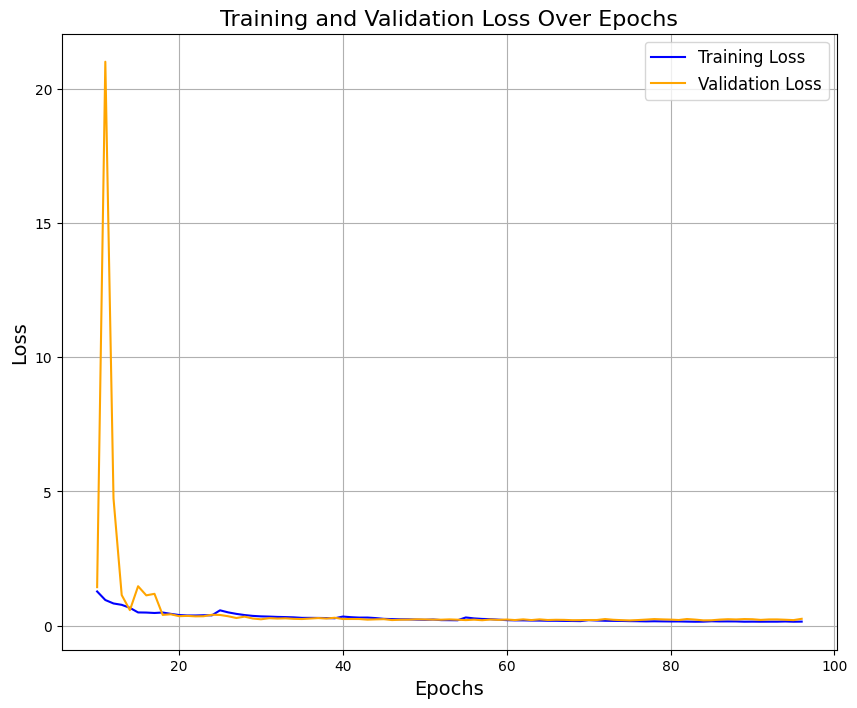

In [20]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 8))
plt.plot(range(10, len(train_loss_list) + 10), train_loss_list, label="Training Loss", color='blue')
plt.plot(range(10, len(val_loss_list) + 10), val_loss_list, label="Validation Loss", color='orange')

# Add titles and labels
plt.title("Training and Validation Loss Over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)


plt.savefig('loss_over_epochs.png', dpi=300)
plt.show()


# Getting the Accuracy

In [18]:
from sklearn.metrics import accuracy_score
import torch


solver.net.eval()

val_accuracy = 0


val_data_loader_iter = iter(val_loader)
for val_img, val_mask in val_data_loader_iter:

    solver.set_input(val_img, val_mask)

    predicted_mask, _ = solver.test_batch()
    predicted_mask = (predicted_mask > 0.5).astype(np.float32)


    predicted_mask = torch.tensor(predicted_mask).to(torch.float32)


    val_accuracy += accuracy_score(val_mask.cpu().numpy().flatten(),
                                   predicted_mask.cpu().numpy().flatten())

val_accuracy /= len(val_data_loader_iter)


print(f'Validation Accuracy: {val_accuracy:.4f}')




<ipython-input-3-240879952428>:61: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.img = V(self.img.to(self.device), volatile=volatile)
<ipython-input-3-240879952428>:63: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.mask = V(self.mask.to(self.device), volatile=volatile)


Validation Accuracy: 0.9589


# Getting the files for submition

In [14]:
test() # calling the function that predicts the test_set_images file and gives us a label for each of them

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-6-199b312c222f>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more deta

0.0      0.00
Testing on  test_1.png
Testing on  test_10.png
Testing on  test_11.png
Testing on  test_12.png
Testing on  test_13.png
Testing on  test_14.png
Testing on  test_15.png
Testing on  test_16.png
Testing on  test_17.png
Testing on  test_18.png
1.0      57.41
Testing on  test_19.png
Testing on  test_2.png
Testing on  test_20.png
Testing on  test_21.png
Testing on  test_22.png
Testing on  test_23.png
Testing on  test_24.png
Testing on  test_25.png
Testing on  test_26.png
Testing on  test_27.png
2.0      115.43
Testing on  test_28.png
Testing on  test_29.png
Testing on  test_3.png
Testing on  test_30.png
Testing on  test_31.png
Testing on  test_32.png
Testing on  test_33.png
Testing on  test_34.png
Testing on  test_35.png
Testing on  test_36.png
3.0      172.13
Testing on  test_37.png
Testing on  test_38.png
Testing on  test_39.png
Testing on  test_4.png
Testing on  test_40.png
Testing on  test_41.png
Testing on  test_42.png
Testing on  test_43.png
Testing on  test_44.png
Testing

In [15]:



import os
import numpy as np
import matplotlib.image as mpimg
import re

foreground_threshold = 0.25

def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(full_path, image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(full_path)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, submission_mask_path, image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            path = os.path.join(submission_mask_path, fn)
            f.writelines('{}\n'.format(s)
                         for s in mask_to_submission_strings(path, fn))


def submit():
    submission_filename = 'DinkNet152.csv'
    submission_mask_path = 'submits/DinkNet152/'
    end = int(len('_mask.png'))
    start = int(len('test_'))
    image_names = os.listdir(submission_mask_path)
    image_names.sort(key=lambda x: int(x[start:][:-end]))
    masks_to_submission(submission_filename, submission_mask_path, image_names)


In [16]:
submit()